# Testing Tradional CV Segmentations Methods (HC)

In [1]:
# Importing required modules
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from os.path import join
from os import listdir
from scipy.signal import savgol_filter
import pandas as pd
from sklearn import svm
import array

## **1. Loading** <a class="anchor" id="1"></a>

In [2]:
def load(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(img)
    return img

In [3]:
def draw(img, c_map='gray'):
    plt.axis('off')
    plt.imshow(img, cmap=c_map)

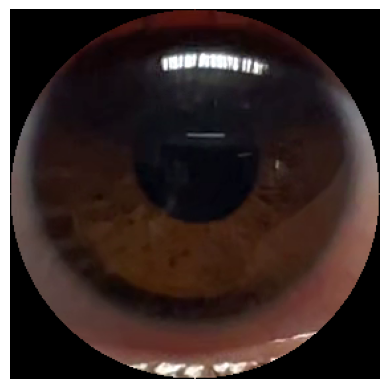

In [4]:
img0 = load('/Users/adityagupta/Desktop/pupillometry/TESTING/Healthy/1/iris/100b.png')

## **2. Preprocessing** <a class="anchor" id="2"></a>

### **2.1 Grayscale**

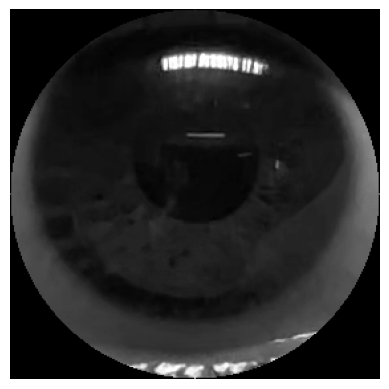

In [5]:
img_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
draw(img_gray)

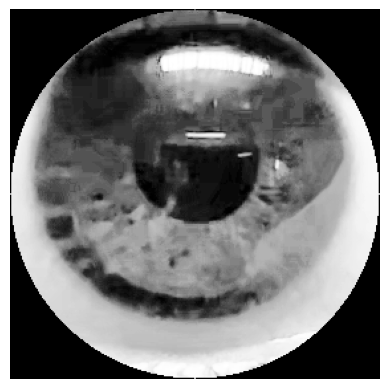

In [6]:
equ = cv2.equalizeHist(img_gray)
draw(equ)

### **2.2 Gaussian Filtering and Median Blur**

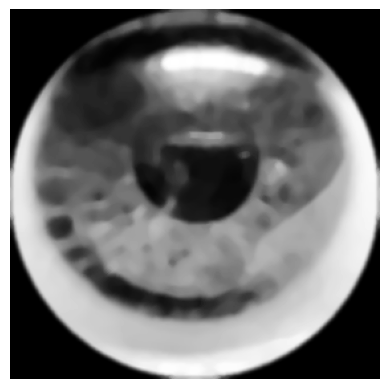

In [7]:
gaus = cv2.GaussianBlur(equ,(7,7),0)
gray = cv2.medianBlur(gaus,7)
plt.axis('off')
plt.imshow(gray, cmap='gray')

### **2.3 Binarization**

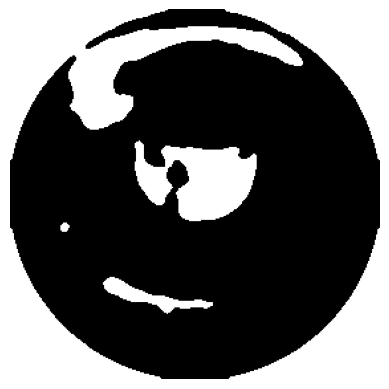

In [8]:
_,thresh = cv2.threshold(gray, 40,255, cv2.THRESH_BINARY_INV)
plt.axis('off')
plt.imshow(thresh, cmap='gray')

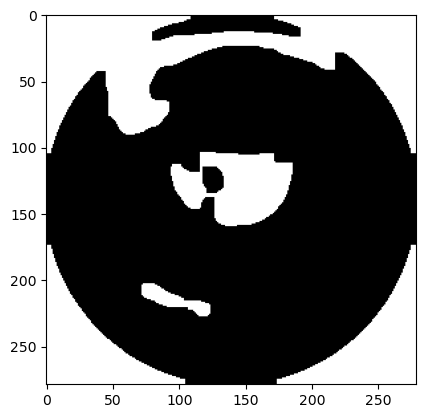

In [9]:
kernel = np.ones((7,7),np.uint8)
kernel_2 = np.ones((7,7),np.uint8)

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_2)

# plt.imshow(opening, cmap='gray')
plt.imshow(closing, cmap='gray')

### Contour/Edge Detection

In [10]:
edges = cv2.dilate(cv2.Canny(closing,0,255),None)

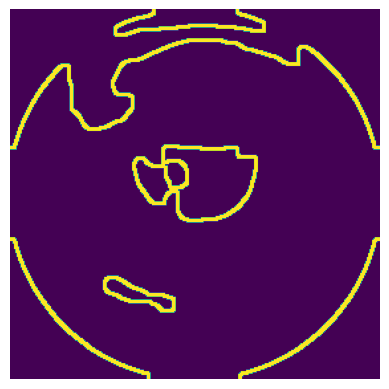

In [11]:
plt.axis('off')
plt.imshow(edges)

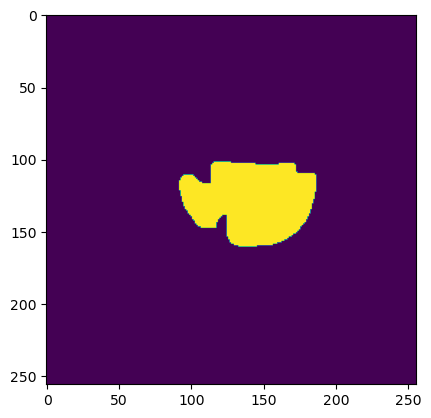

In [12]:
from scipy.spatial import distance
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-3:]

image_center = np.asarray(edges.shape) / 2
image_center = tuple(image_center.astype('int32'))

cns = []

for contour in cnt:
    # find center of each contour
    M = cv2.moments(contour)
    center_X = int(M["m10"] / M["m00"])
    center_Y = int(M["m01"] / M["m00"])
    contour_center = (center_X, center_Y)
    
    # calculate distance to image_center
    distances_to_center = (distance.euclidean(image_center, contour_center))
    
    cns.append({'contour': contour, 'center': contour_center, 'distance_to_center': distances_to_center})

closest_cnts = sorted(cns, key=lambda i: i['distance_to_center'])
cnt= closest_cnts[0]['contour']
                               
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.imshow(masked)

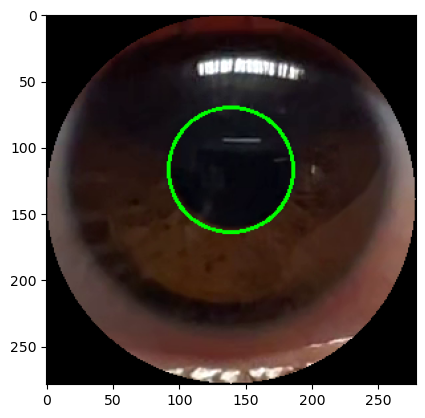

In [13]:
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
cv2.circle(img0,center,radius,(0,255,0),2)
plt.imshow(img0)

## Misc Preprocessing

In [585]:
time = {
    '1': [slice(54,100), slice(133,219)],
    '2': [slice(102,234)],
    '3': [slice(95,227)],
    '4': [slice(73,205)], #418
    '5': [slice(94,226)]
}
pupils = {}
for i in range(1,6):
    pupil = pd.read_csv(f"TESTING/Healthy/{i}/diam.csv").to_numpy()
    pupils[f"{i}"] = pupil.ravel()
    

def frames(i):
    slices = time[str(i)]
    sizes = np.array([])
    for sl in slices:
        sizes = np.append(sizes, pupils[str(i)][sl])
    return sizes.ravel()
#     values = sizes.ravel()
#     maximum = max(values)
#     return values/maximum

In [587]:
len(frames(4))

132

In [588]:
for i in range(1,6):
    print(len(frames(i)))

132
132
132
132
132


In [589]:
def plot_pfr(i, save=False):
    yhat = savgol_filter(frames(i), 39, 3)
    plt.plot(yhat, color='green')
    plt.vlines(x=[29,102],ymin=0.15, ymax=0.35,colors='orange', ls='--', lw=2, label='contraction')
    plt.xlabel('Frame (60Hz) = 1/60 seconds')
    plt.ylabel('Pupil/Mediapipe Iris Size Ratio')
    plt.title('Pupil Flash Response')
    plt.annotate("", xy=(29, 0.35), xytext=(55, 0.35), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
    plt.annotate("Flash On", xy=(102, 0.35), xytext=(55, 0.35), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
    if save:
        plt.savefig(f"PFR{i}.png", dpi=500)
    return

In [ ]:
plot_pfr(1)

In [721]:
grad = np.gradient(yhat)
print(min(grad))

-0.0034090428904539755


In [643]:
def plot_pfr(i, save=False):
    yhat = savgol_filter(frames(i), 39, 3)
    fig, ax = plt.subplots()
    ax.vlines(x=[29,102],ymin=0.15, ymax=0.35,colors='orange', ls='--', lw=2, label='contraction')
    ax.set_xlabel('Frame (60Hz) = 1/60 seconds')
    ax.set_ylabel('Pupil/Mediapipe Iris Size Ratio')
    ax.set_title('Pupil Flash Response')
    ax.annotate("", xy=(29, 0.35), xytext=(55, 0.35), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
    ax.annotate("Flash On", xy=(102, 0.35), xytext=(55, 0.35), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
    ax.plot(yhat, color='green')
    if save:
        plt.savefig(f"PFR{i}.png", dpi=500)
    return ax

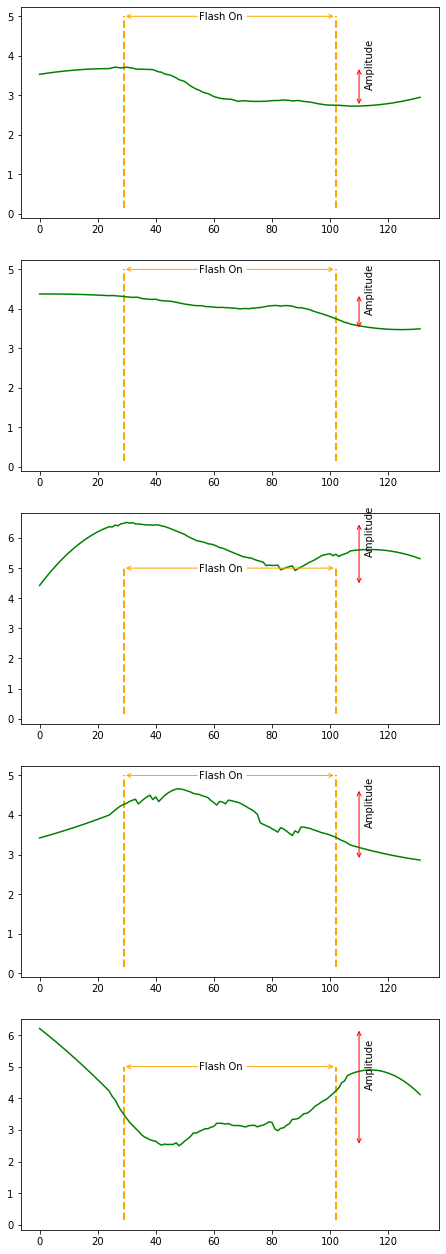

In [739]:
MCV = []
AMP = []
CV = []
def display_axes(axes):
    for i, ax in enumerate(axes.ravel()):
        ax.vlines(x=[29,102],ymin=0.15, ymax=5,colors='orange', ls='--', lw=2, label='contraction')
#         ax.set_xlabel('Frame (60Hz) = 1/60 seconds')
#         ax.set_ylabel('Pupil/Mediapipe Iris Size Ratio')
#         ax.set_title('Pupil Flash Response')
        ax.annotate("", xy=(29, 5), xytext=(55, 5), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
        ax.annotate("Flash On", xy=(102, 5), xytext=(55, 5), arrowprops={"arrowstyle":"->", "color":"orange"},va='center')
        yhat = savgol_filter(frames(i+1), 49, 2)
        ma = max(yhat)
        mi = min(yhat)
        max_ind = np.argmax(yhat)
        min_ind = np.argmin(yhat)
        diff = ma-mi
        AMP.append(diff)
        loc = (ma + mi)/2
        CV.append(diff/(max_ind-min_ind)*60)
#         ax.vlines(x=[110],ymin=mi, ymax=ma,colors='red', ls='-', lw=2, label='contraction')
        ax.annotate("", xy=(110, mi), xytext=(110, ma), arrowprops={"arrowstyle":"<->", "color":"red"},va='center')
        ax.text(112,loc-0.025,'Amplitude',rotation=90)
        grad = np.gradient(yhat)
        MCV.append(min(grad)*60)
        ax.plot(yhat, color='green')
        plt.savefig('HC1.png')
# create figures and (2x2) axes array
fig, axes = plt.subplots(5, figsize=(7.5,22.5))
# fig.suptitle('Pupil Flash Response for each Participant')
# four (2*2=4) axes
ax1, ax2, ax3, ax4, ax5 = axes.ravel()
# for illustration purpose
display_axes(axes)

In [601]:
MCV

[-3.4213498717168944,
 -2.4391177720947743,
 -5.720048177752304,
 -11.128071742115516,
 -12.87346975698731]

In [602]:
CV

[-0.8311680727684759,
 -0.5445206797857458,
 3.8293919756524315,
 -1.3827685142134254,
 -5.603005463412163]

In [599]:
AMP

[1.038960090960595,
 0.952911189625055,
 2.297635185391459,
 1.9128297779952383,
 3.361803278047298]

In [648]:
def figure():
    fig, axs = plt.subplots(5)
    fig.suptitle('Pupil Flash Response for each Participant')
    for i in range(5):
        plot = plot_pfr(i+1)
        axs[i] = plot
    plt.show()

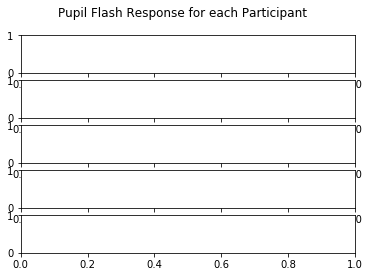

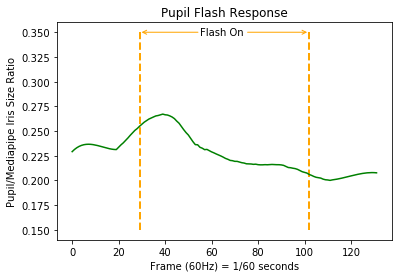

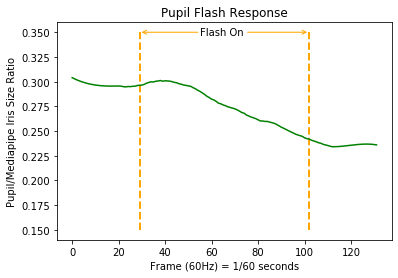

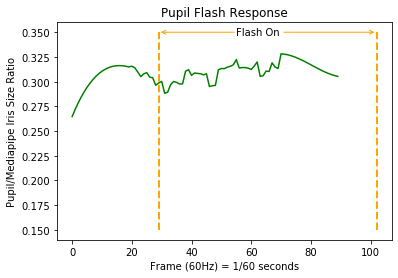

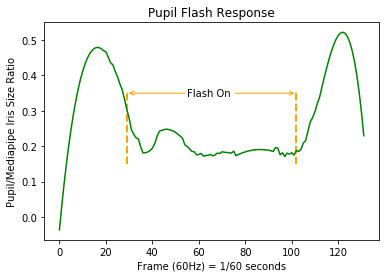

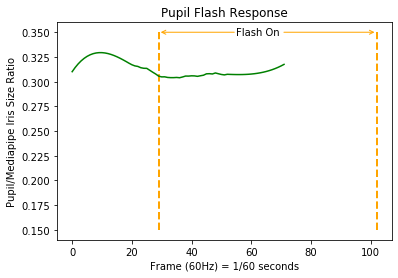

In [649]:
figure()

In [538]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [179]:
from scipy.interpolate import make_interp_spline
x = np.array([i for i in range(len(lis))])

In [180]:
X_Y_Spline = make_interp_spline(x, lis)

In [193]:
X_ = np.linspace(x.min(), x.max(), 100)
Y_ = X_Y_Spline(X_)

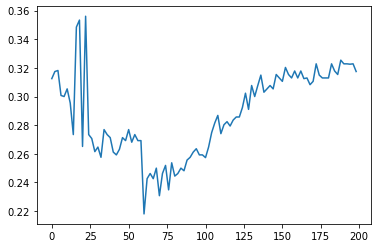

In [194]:
plt.plot(X_, Y_)

In [ ]:
plt.savefig('books_read.png')

In [ ]:
for i in range(20, 50):
    diam = []
    gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    gray = cv2.GaussianBlur(equ,(5,5),0)
    kernel = np.ones((7,7),np.uint8)
    kernel2 = np.ones((20,20),np.uint8)
    _,thresh = cv2.threshold(gray, i, 255, cv2.THRESH_BINARY_INV)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
    edges = cv2.dilate(cv2.Canny(closing,0,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    diam.append(radius*2/(int(r_radius)*2))
    cv2.circle(result,center,radius,(0,255,0),2)